In [38]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
%matplotlib inline
import matplotlib.pyplot as plt

# 1 - Data cleaning

In [57]:
# Importing datasets

original_df_csv = pd.read_csv("Original_dataset/cyberbullying.csv")
original_df_xlsx = pd.read_excel("Original_dataset/1 - cyberbullying_in_social_media.xlsx") #A des problème d'encodage sur la colonne "Text", "SendenLocation", on va utilisé celle du CSV qui n'a pas le problème.

# NB : on ne prend pas le CSV complet car le nombre (notamment "Id" sont arrondie ce qui pose des problèmes de duplications)

### 1.1 Ecoding issues

In [ ]:
#Merge CSV and XLSX

clean_df = original_df_xlsx
clean_df["Text"] = original_df_csv["Text"]
clean_df["SenderLocation"] = original_df_csv["SenderLocation"]

### 1.2 General cleaning

In [ ]:
#Drop "IdRetweet"

original_df_xlsx["IsRetweet"].value_counts() #Cette colonne n'apporte aucune info, on va la supprimer.
clean_df = clean_df.drop(columns=["IsRetweet"])

In [ ]:
#Cleaning "Id"

clean_df["Id"] = clean_df["Id"].astype(int)
#clean_df["Id"][clean_df.duplicated()] #On vérifie qu'il n'y ait pas de doublon

In [ ]:
#Cleaning "SenderAccountYears"
clean_df["SenderAccountYears"].value_counts() # 2020 :4, 1200 : 1 -> on supprime les lignes en question

clean_df = clean_df.drop(clean_df[(clean_df["SenderAccountYears"] == 2020) | (clean_df["SenderAccountYears"] == 1200)].index) 

In [ ]:
# Clean columns names
clean_df.columns = [x.replace("#","") for x in list(clean_df.columns)]

### 1.3 SenderLocation cleaning

In [ ]:
cities_df = pd.read_csv("worldcities.csv")
cities = cities_df["city"] # On ne garde pas que les ville Turque, on veut aussi match Oslo par exemple 
cities = [city.lower() for city in cities]

In [ ]:
print(cities)

In [ ]:
# Define the replacement dictionary
replacements = {
    'Türkiye':'turkey',
    'turkiye':'turkey',
    'türkiye':'turkey',
    'turkeykocaeliizmit':'turkey',
    'istanbulturkey':'istanbul',
    'istanbulzeytinburnu':'istanbul',
    'na':np.nan,
    'NA':np.nan,
    '3406':'istanbul', #because 03406 is postal code of istanbul
    '':np.nan,
    'üsküdar': 'istanbul', #un disctict d'Istambul
    'istabul':'istanbul',
    'karşıyaka':'turkey', #un district turque    
}
# Replace values in the senderlocation column based on the replacements dictionary
clean_df['SenderLocation'] = clean_df['SenderLocation'].replace(replacements, regex=True)

In [ ]:
custom_match_places = cities + ["turkey","izmir","karşıyaka"]

In [ ]:
locations_not_match = [city for city in clean_df["SenderLocation"] if city not in custom_match_places and not pd.isnull(city)]

# problème de match avec "i̇"

In [ ]:
pd.isnull(locations_not_match[0])

# 2 - To SQL

In [28]:
# To SQL
pw = "password1999"
connection_string = 'mysql+pymysql://root:' + pw + '@localhost:3306/'
engine = create_engine(connection_string)

In [ ]:
clean_df.to_sql("main",schema="datacleaning", con = engine)

# 2 bis - To CSV

In [58]:
clean_df.to_csv("clean_dataset.csv")

# 3 - Data visualisation

In [32]:
pw = "password1999"
connection_string = 'mysql+pymysql://root:' + pw + '@localhost:3306/datacleaning'
engine = create_engine(connection_string)

sql = ''' 
SELECT *
FROM cyberbullies_acount_profil; 
'''

cyberbullies_acount_profil = pd.read_sql(sql,engine)

In [39]:
sql = ''' 
SELECT *
FROM no_cyberbullies_acount_profil; 
'''

no_cyberbullies_acount_profil = pd.read_sql(sql,engine)

array([[<Axes: title={'center': 'SenderId'}>,
        <Axes: title={'center': 'SenderAccountYears'}>],
       [<Axes: title={'center': 'SenderFavorites'}>,
        <Axes: title={'center': 'SenderFollowings'}>],
       [<Axes: title={'center': 'SenderFollowers'}>,
        <Axes: title={'center': 'SenderStatues'}>]], dtype=object)

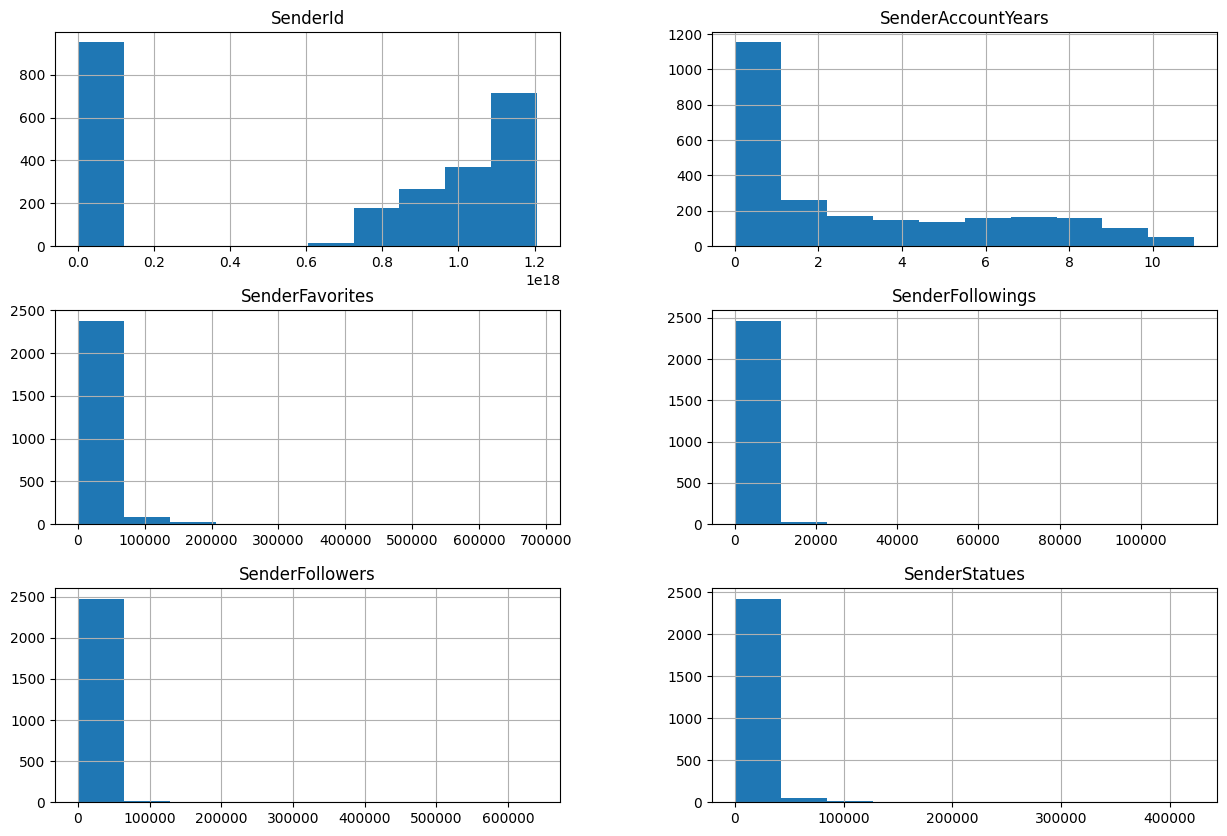

In [37]:
cyberbullies_acount_profil.hist(figsize=(15, 10))

In [43]:
cyberbullies_acount_profil.head()

,SenderId,SenderAccountYears,SenderFavorites,SenderFollowings,SenderFollowers,SenderStatues,SenderLocation
0,1184090243072450560,0,286,651,676.0,60,None
1,1207067359342710784,0,0,0,0.0,303,None
2,817092980691582976,2,5889,485,555.0,1937,None
3,2976760841,4,10508,599,1009.0,738,None
4,2544218838,5,2603,138,102.0,1079,turkey


Text(0.5, 1.0, 'Sender acount years')

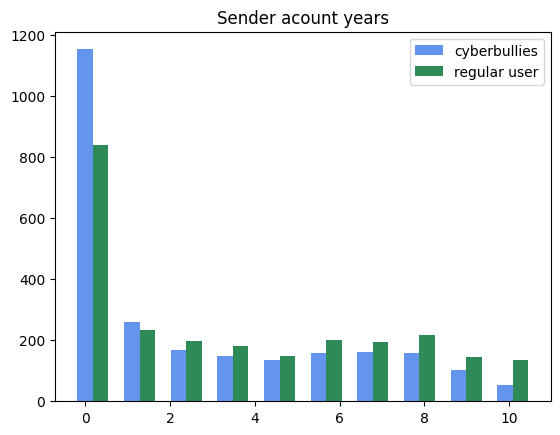

In [50]:
%matplotlib inline

fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(cyberbullies_acount_profil["SenderAccountYears"])
b_heights, b_bins = np.histogram(no_cyberbullies_acount_profil["SenderAccountYears"], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue',label = "cyberbullies")
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen',label = "regular user")

ax.legend(loc='upper right')
ax.set_title("Sender acount years")

In [53]:
cyberbullies_acount_profil["SenderFollowers"]

0          676.0
1            0.0
2          555.0
3         1009.0
4          102.0
          ...   
2495       875.0
2496    207664.0
2497     86126.0
2498      8885.0
2499      1985.0
Name: SenderFollowers, Length: 2500, dtype: float64

Text(0.5, 1.0, 'Sender followers')

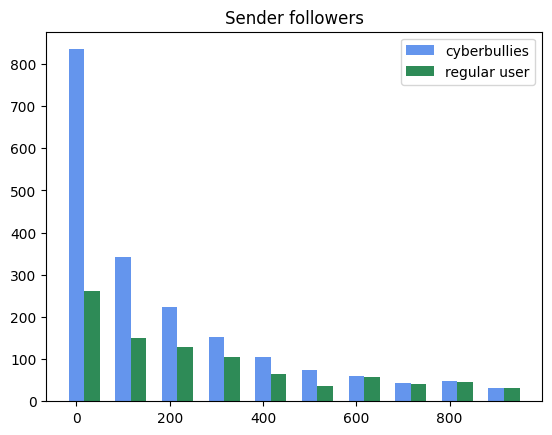

In [59]:
%matplotlib inline

fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(cyberbullies_acount_profil["SenderFollowers"], range=[0,1000])
b_heights, b_bins = np.histogram(no_cyberbullies_acount_profil["SenderFollowers"], bins=a_bins, range=[0,1000])

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue',label = "cyberbullies")
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen',label = "regular user")

ax.legend(loc='upper right')
ax.set_title("Sender followers")